# Open Source RAG - Leveraging Hugging Face Endpoints through LangChain

In the following notebook we will dive into the world of Open Source models hosted on Hugging Face's [inference endpoints](https://ui.endpoints.huggingface.co/).

The notebook will be broken into the following parts:

- 🤝 Breakout Room #2:
  1. Install required libraries
  2. Set Environment Variables
  3. Creating LangChain components powered by the endpoints
  4. Creating a simple RAG pipeline with [LangChain v0.2.0](https://blog.langchain.dev/langchain-v02-leap-to-stability/)

## Task 1: Install required libraries

Now we've got to get our required libraries!

We'll start with our `langchain` and `huggingface` dependencies.



In [1]:
!pip install -qU langchain-huggingface langchain-community faiss-cpu

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ragas 0.1.20 requires langchain-core<0.3, but you have langchain-core 0.3.9 which is incompatible.


## Task 2: Set Environment Variables

We'll need to set our `HF_TOKEN` so that we can send requests to our protected API endpoint.

We'll also set-up our OpenAI API key, which we'll leverage later.



In [2]:
import os
import getpass

os.environ["HF_TOKEN"] = getpass.getpass("HuggingFace Write Token: ")

## Task 3: Creating LangChain components powered by the endpoints

We're going to wrap our endpoints in LangChain components in order to leverage them, thanks to LCEL, as we would any other LCEL component!

### HuggingFaceEndpoint for LLM

We can use the `HuggingFaceEndpoint` found [here](https://github.com/langchain-ai/langchain/blob/master/libs/community/langchain_community/llms/huggingface_endpoint.py) to power our chain - let's look at how we would implement it.

In [3]:
YOUR_LLM_ENDPOINT_URL = "https://qets3u3wakzgplt2.us-east-1.aws.endpoints.huggingface.cloud"

In [4]:
from langchain_community.llms import HuggingFaceEndpoint

hf_llm = HuggingFaceEndpoint(
    endpoint_url=f"{YOUR_LLM_ENDPOINT_URL}",
    max_new_tokens=512,
    top_k=10,
    top_p=0.95,
    typical_p=0.95,
    temperature=0.01,
    repetition_penalty=1.03,
    huggingfacehub_api_token=os.environ["HF_TOKEN"]
)

/var/folders/s4/zblsys792ms27n7gzbf6nt340000gn/T/ipykernel_73685/1258114758.py:3: LangChainDeprecationWarning: The class `HuggingFaceEndpoint` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEndpoint``.
  hf_llm = HuggingFaceEndpoint(
/opt/homebrew/Caskroom/miniforge/base/envs/llmops-course/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/danielgutierrez/.cache/huggingface/token
Login successful


Now we can use our endpoint like we would any other LLM!

In [5]:
hf_llm.invoke("Hello, how are you?")

" I hope you're having a great day! I'm excited to share with you my latest project, a beautiful and cozy home office design. As someone who spends a lot of time working from home, I know how important it is to have a space that is both functional and comfortable. That's why I've created this design, which combines the best of both worlds.\n\nThe first thing you'll notice about this design is the warm and inviting color scheme. The walls are painted a soothing shade of beige, and the furniture is a combination of rich wood tones and soft, creamy colors. The result is a space that feels like a cozy retreat, perfect for focusing on your work or simply relaxing.\n\nOne of the key features of this design is the use of natural light. The room is flooded with sunlight during the day, thanks to the large windows that let in plenty of natural light. This not only makes the space feel brighter and more airy, but it also helps to reduce the need for artificial lighting.\n\nAnother important aspe

Now we can add a RAG-style prompt using Llama 3 Instruct's prompt templating!

In [6]:
from langchain_core.prompts import PromptTemplate

RAG_PROMPT_TEMPLATE = """\
<|start_header_id|>system<|end_header_id|>
You are a helpful assistant. You answer user questions based on provided context. If you can't answer the question with the provided context, say you don't know.<|eot_id|>

<|start_header_id|>user<|end_header_id|>
User Query:
{query}

Context:
{context}<|eot_id|>

<|start_header_id|>assistant<|end_header_id|>
"""

rag_prompt = PromptTemplate.from_template(RAG_PROMPT_TEMPLATE)

Let's create a simple LCEL chain using our prompt template Runnable and our LLM Runnable.

In [7]:
rag_chain = rag_prompt | hf_llm

In [8]:
rag_chain.invoke({"query" : "Who old is Carl?", "context" : "Carl is a sweet dude, he's 40."})

'According to the context, Carl is 40 years old.'

### HuggingFaceInferenceAPIEmbeddings

Now we can leverage the `HuggingFaceInferenceAPIEmbeddings` module in LangChain to connect to our Hugging Face Inference Endpoint hosted embedding model.

In [9]:
from langchain_huggingface.embeddings import HuggingFaceEndpointEmbeddings

YOUR_EMBED_MODEL_URL = "https://rusg4dwzsfkq5vjf.us-east-1.aws.endpoints.huggingface.cloud"

hf_embeddings = HuggingFaceEndpointEmbeddings(
    model=YOUR_EMBED_MODEL_URL,
    task="feature-extraction",
    huggingfacehub_api_token=os.environ["HF_TOKEN"],
)

Let's build a simple cosine-similarity function to verify our endpoint is working as expected.

In [10]:
import numpy as np
from numpy.linalg import norm

def cosine_similarity(phrase_1, phrase_2):
  vec_1 = hf_embeddings.embed_documents([phrase_1])[0]
  vec2_2 = hf_embeddings.embed_documents([phrase_2])[0]
  return np.dot(vec_1, vec2_2) / (norm(vec_1) * norm(vec2_2))

Let's try a few examples below!

In [11]:
cosine_similarity("I love my fluffy dog!", "I adore this furry puppy!")

0.8903063446222078

In [12]:
cosine_similarity("I love my fluffy dog!", "Eating pizza is the worst! Yuck!")

0.7430207919303136

## Task 4: Preparing Data!

We'll start by loading some data from GitHub (Paul Graham's Essays) and then move to chunking them into manageable pieces!

First - let's grab the repository where the files live.

In [13]:
!git clone https://github.com/dbredvick/paul-graham-to-kindle.git

Cloning into 'paul-graham-to-kindle'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 36 (delta 3), reused 31 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (36/36), 2.35 MiB | 2.47 MiB/s, done.
Resolving deltas: 100% (3/3), done.


Next - we can load them using LangChain!

In [14]:
from langchain_community.document_loaders import TextLoader

document_loader = TextLoader("./paul-graham-to-kindle/paul_graham_essays.txt")
documents = document_loader.load()

Now, let's split them into 1000 character pieces.

In [15]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=30)
split_documents = text_splitter.split_documents(documents)
len(split_documents)

4265

Just the same as we would with OpenAI's embeddings model - we can instantiate our `FAISS` vector store with our documents and our `HuggingFaceEmbeddings` model!

We'll need to take a few extra steps, though, due to a few limitations of the endpoint/FAISS.

We'll start by embeddings our documents in batches of `32`.

> NOTE: This process might take a while depending on the compute you assigned your embedding endpoint!

In [16]:
from langchain_community.vectorstores import FAISS

for i in range(0, len(split_documents), 32):
  if i == 0:
    vectorstore = FAISS.from_documents(split_documents[i:i+32], hf_embeddings)
    continue
  vectorstore.add_documents(split_documents[i:i+32])

Next, we set up FAISS as a retriever.

In [17]:
hf_retriever = vectorstore.as_retriever()

## Task 5: Simple LCEL RAG Chain

Now we can set up our LCEL RAG chain!

> NOTE: We're not returning context for this example, and only returning the text output from the LLM.

In [18]:
from operator import itemgetter
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough

lcel_rag_chain = {"context": itemgetter("query") | hf_retriever, "query": itemgetter("query")}| rag_prompt | hf_llm

In [20]:
lcel_rag_chain.invoke({"query" : "What is the best part of Silicon Valley?"})

'Based on the provided context, it seems that Paul Graham, the author, is discussing the shortcomings of Silicon Valley and how it could be improved. He mentions that the best part of Silicon Valley is not the physical buildings, but rather the people who make it Silicon Valley.\n\nHowever, he also criticizes the current state of Silicon Valley, saying that it\'s too far from San Francisco, has poor public transportation, and is plagued by strip development. He suggests that a better Silicon Valley would prioritize public transportation, pedestrian-friendly design, and a strong university to attract top talent.\n\nSo, the "best part" of Silicon Valley, according to Paul Graham, is not a specific location or feature, but rather the potential for improvement and the opportunity to create a better environment for startups and innovation.'

## Application running in Hugging Face

![HF App Running.png](<attachment:HF App Running.png>)
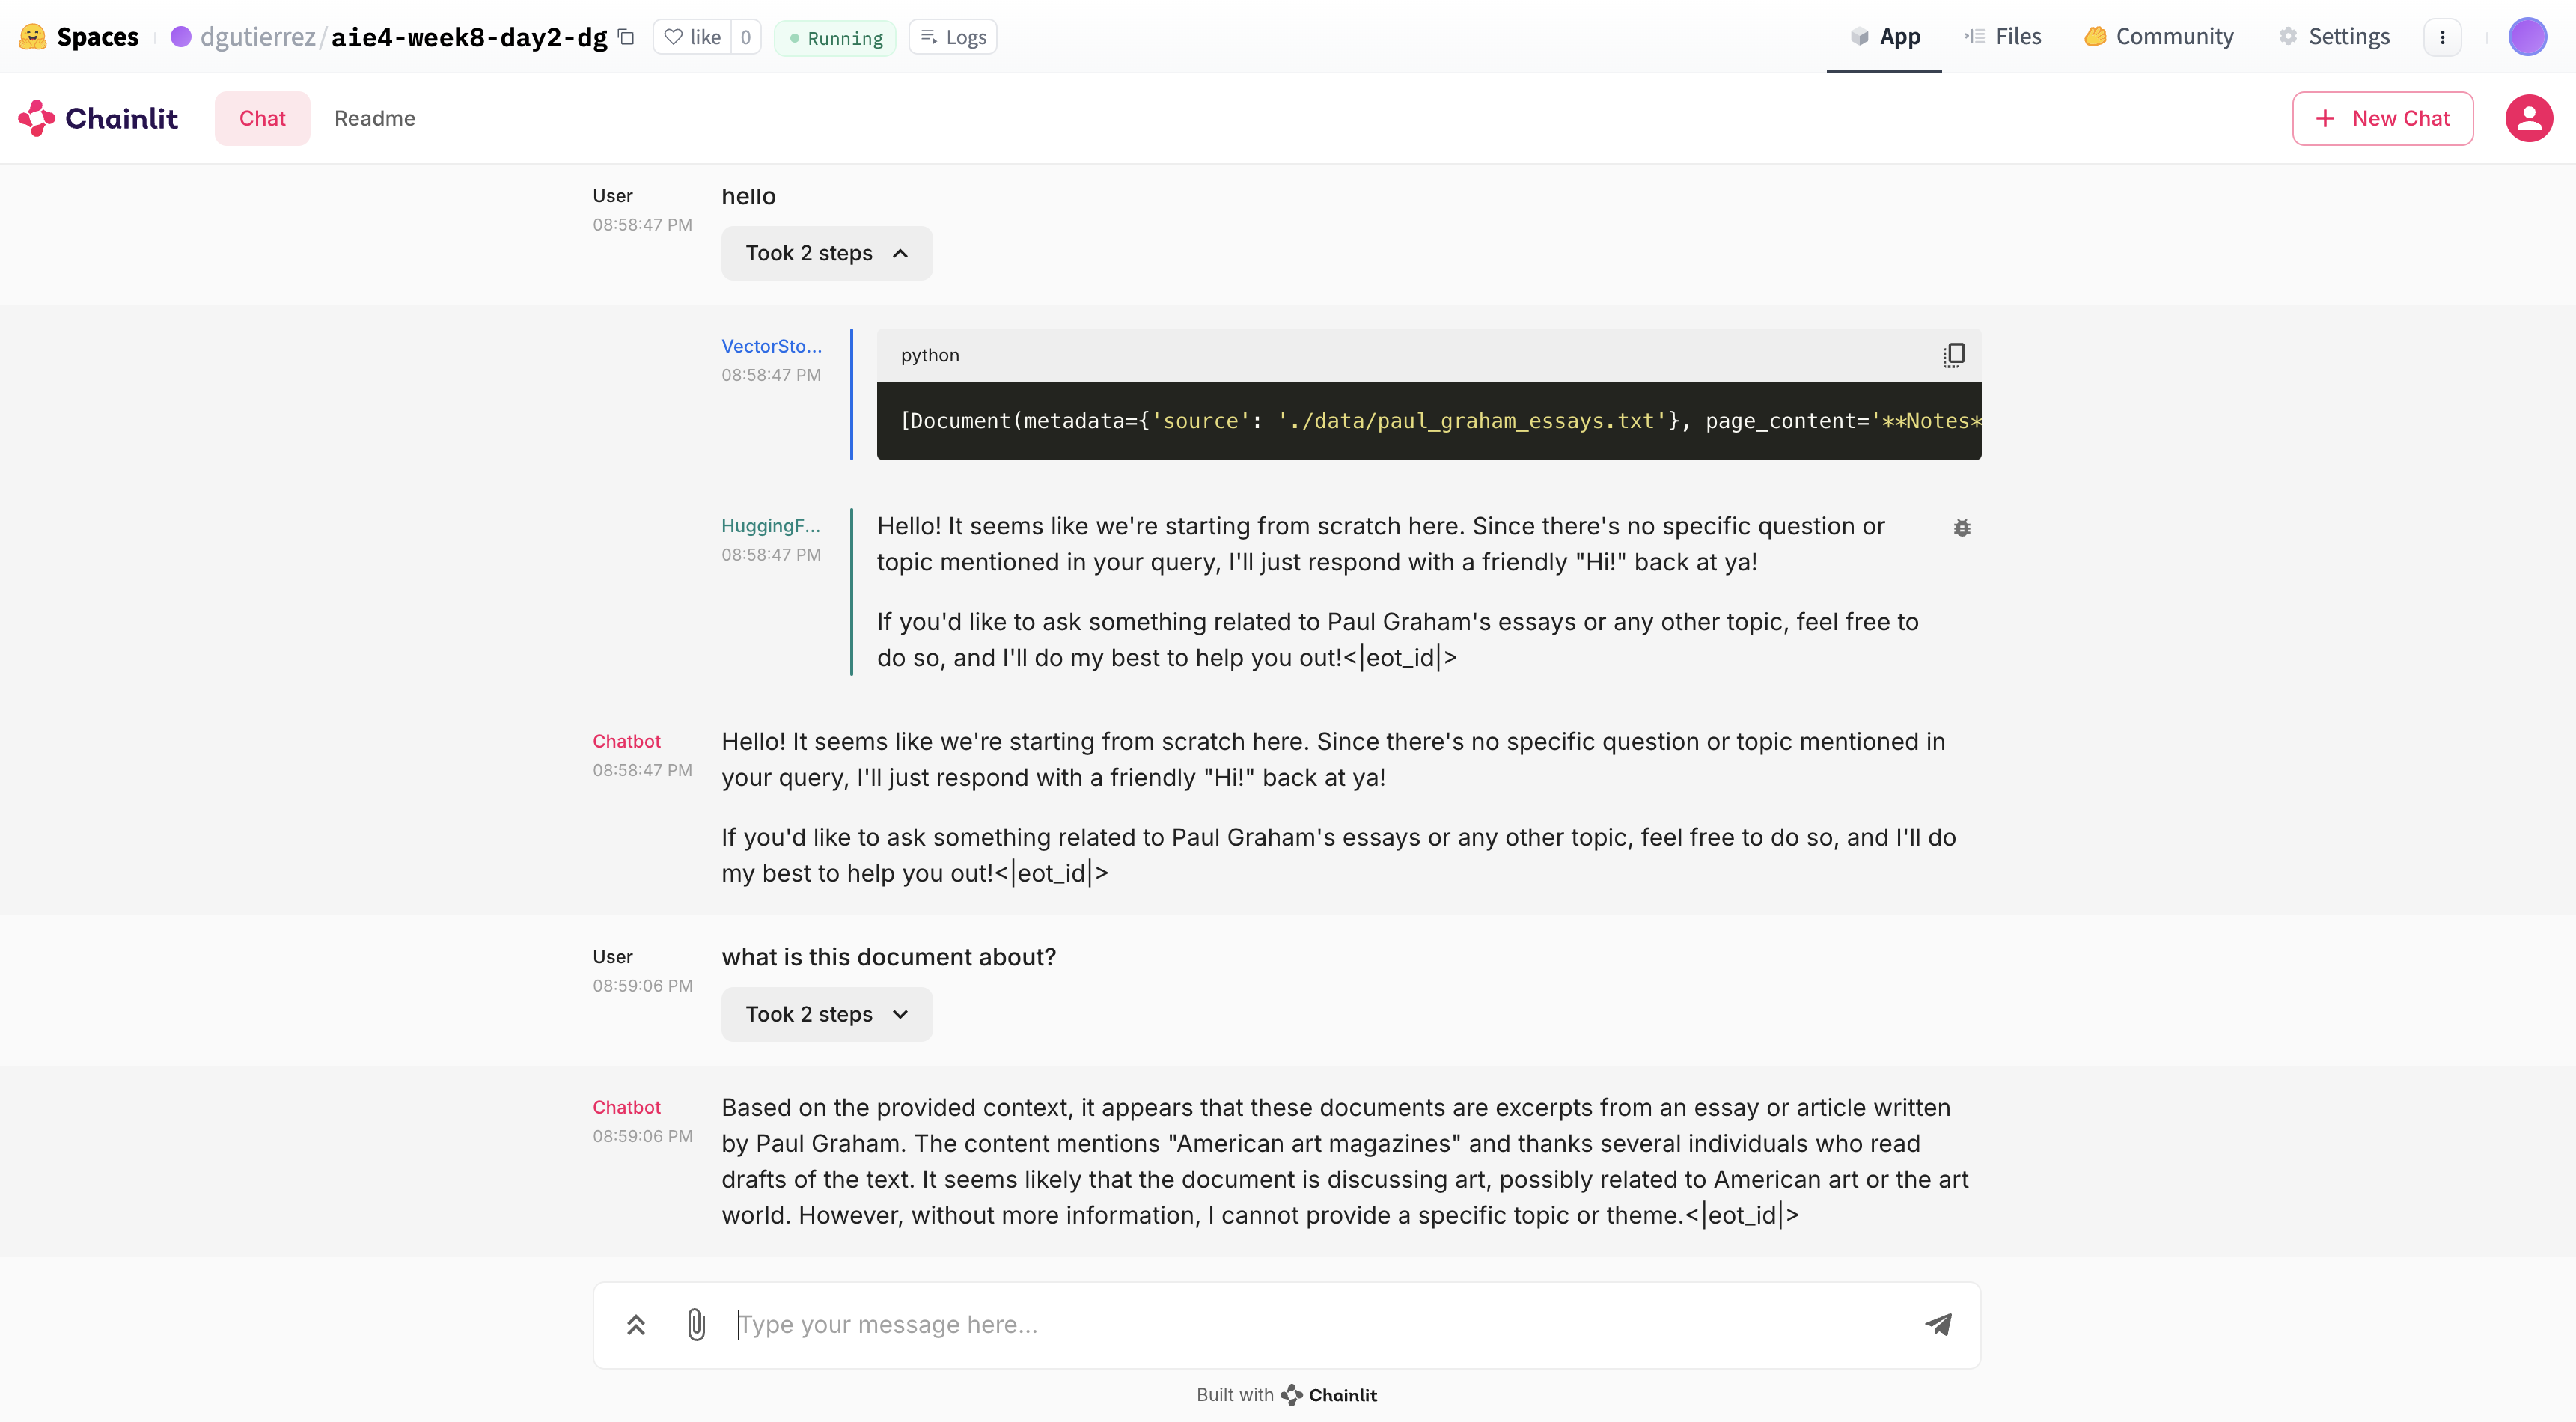

## Inference Endpoints Analytics

![IE LLM Analytics.png](<attachment:IE LLM Analytics.png>)

![IE Embeddings Analytics.png](<attachment:IE Embeddings Analytics.png>)
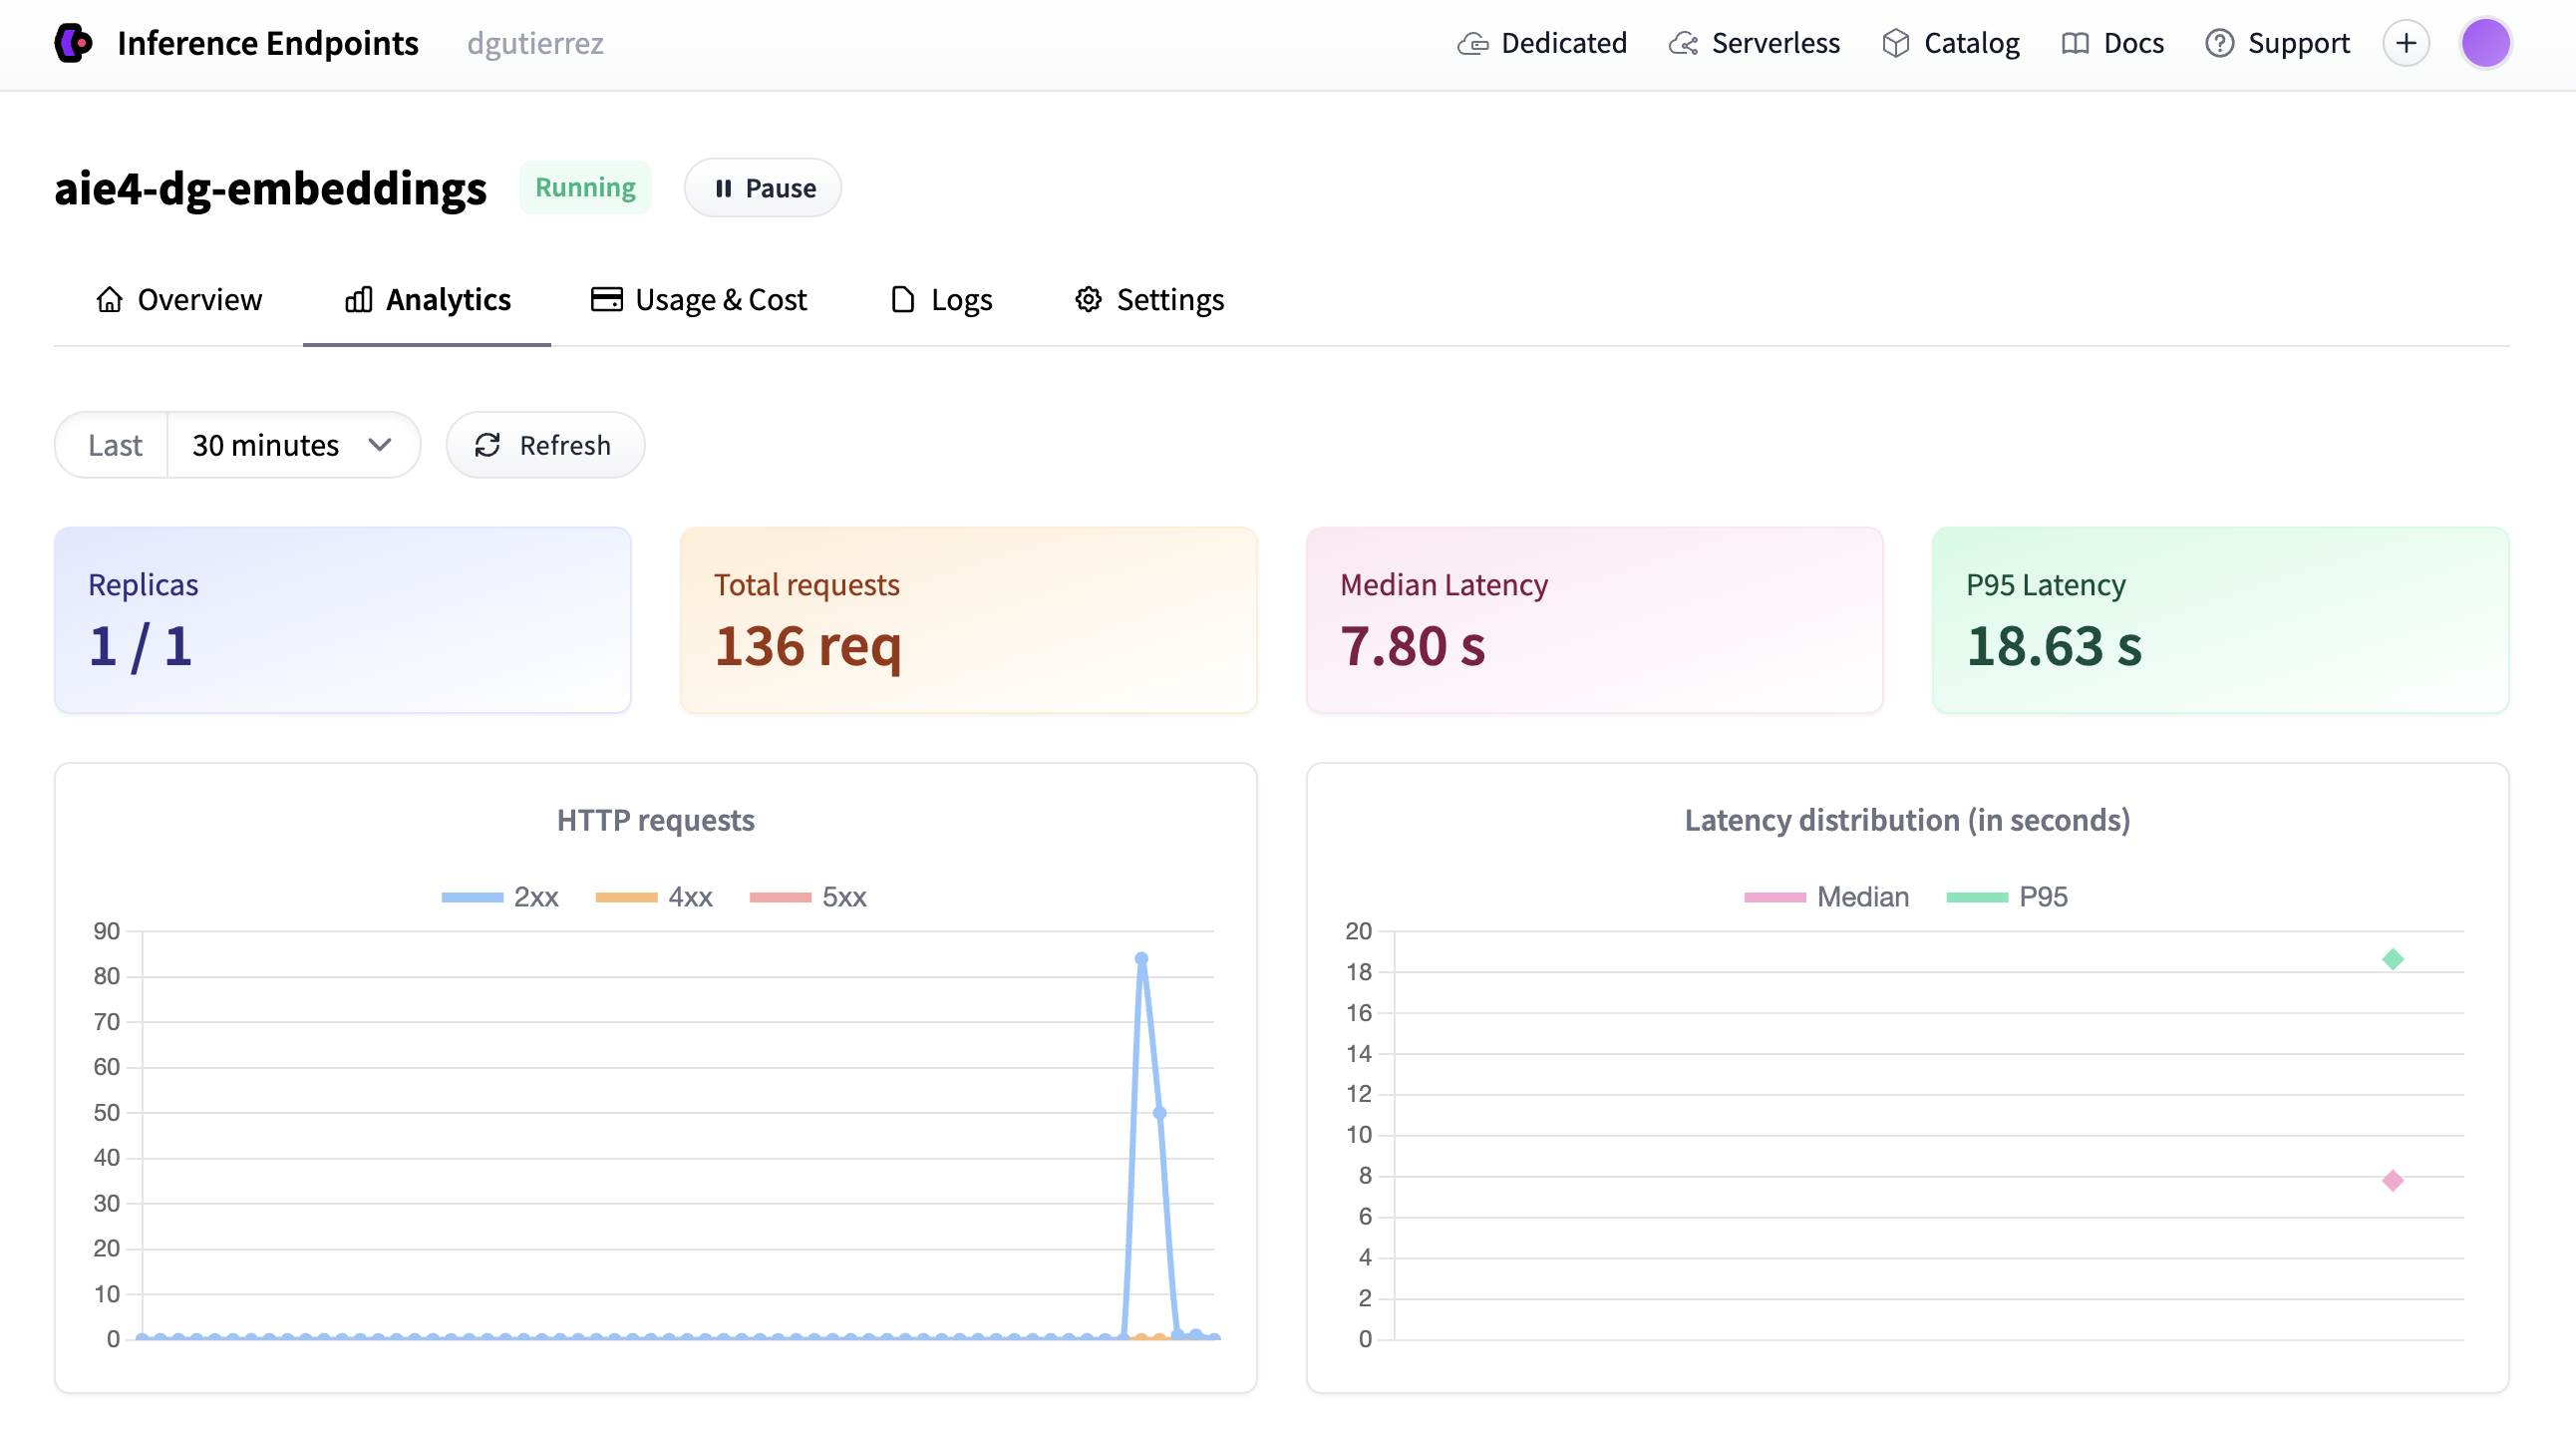
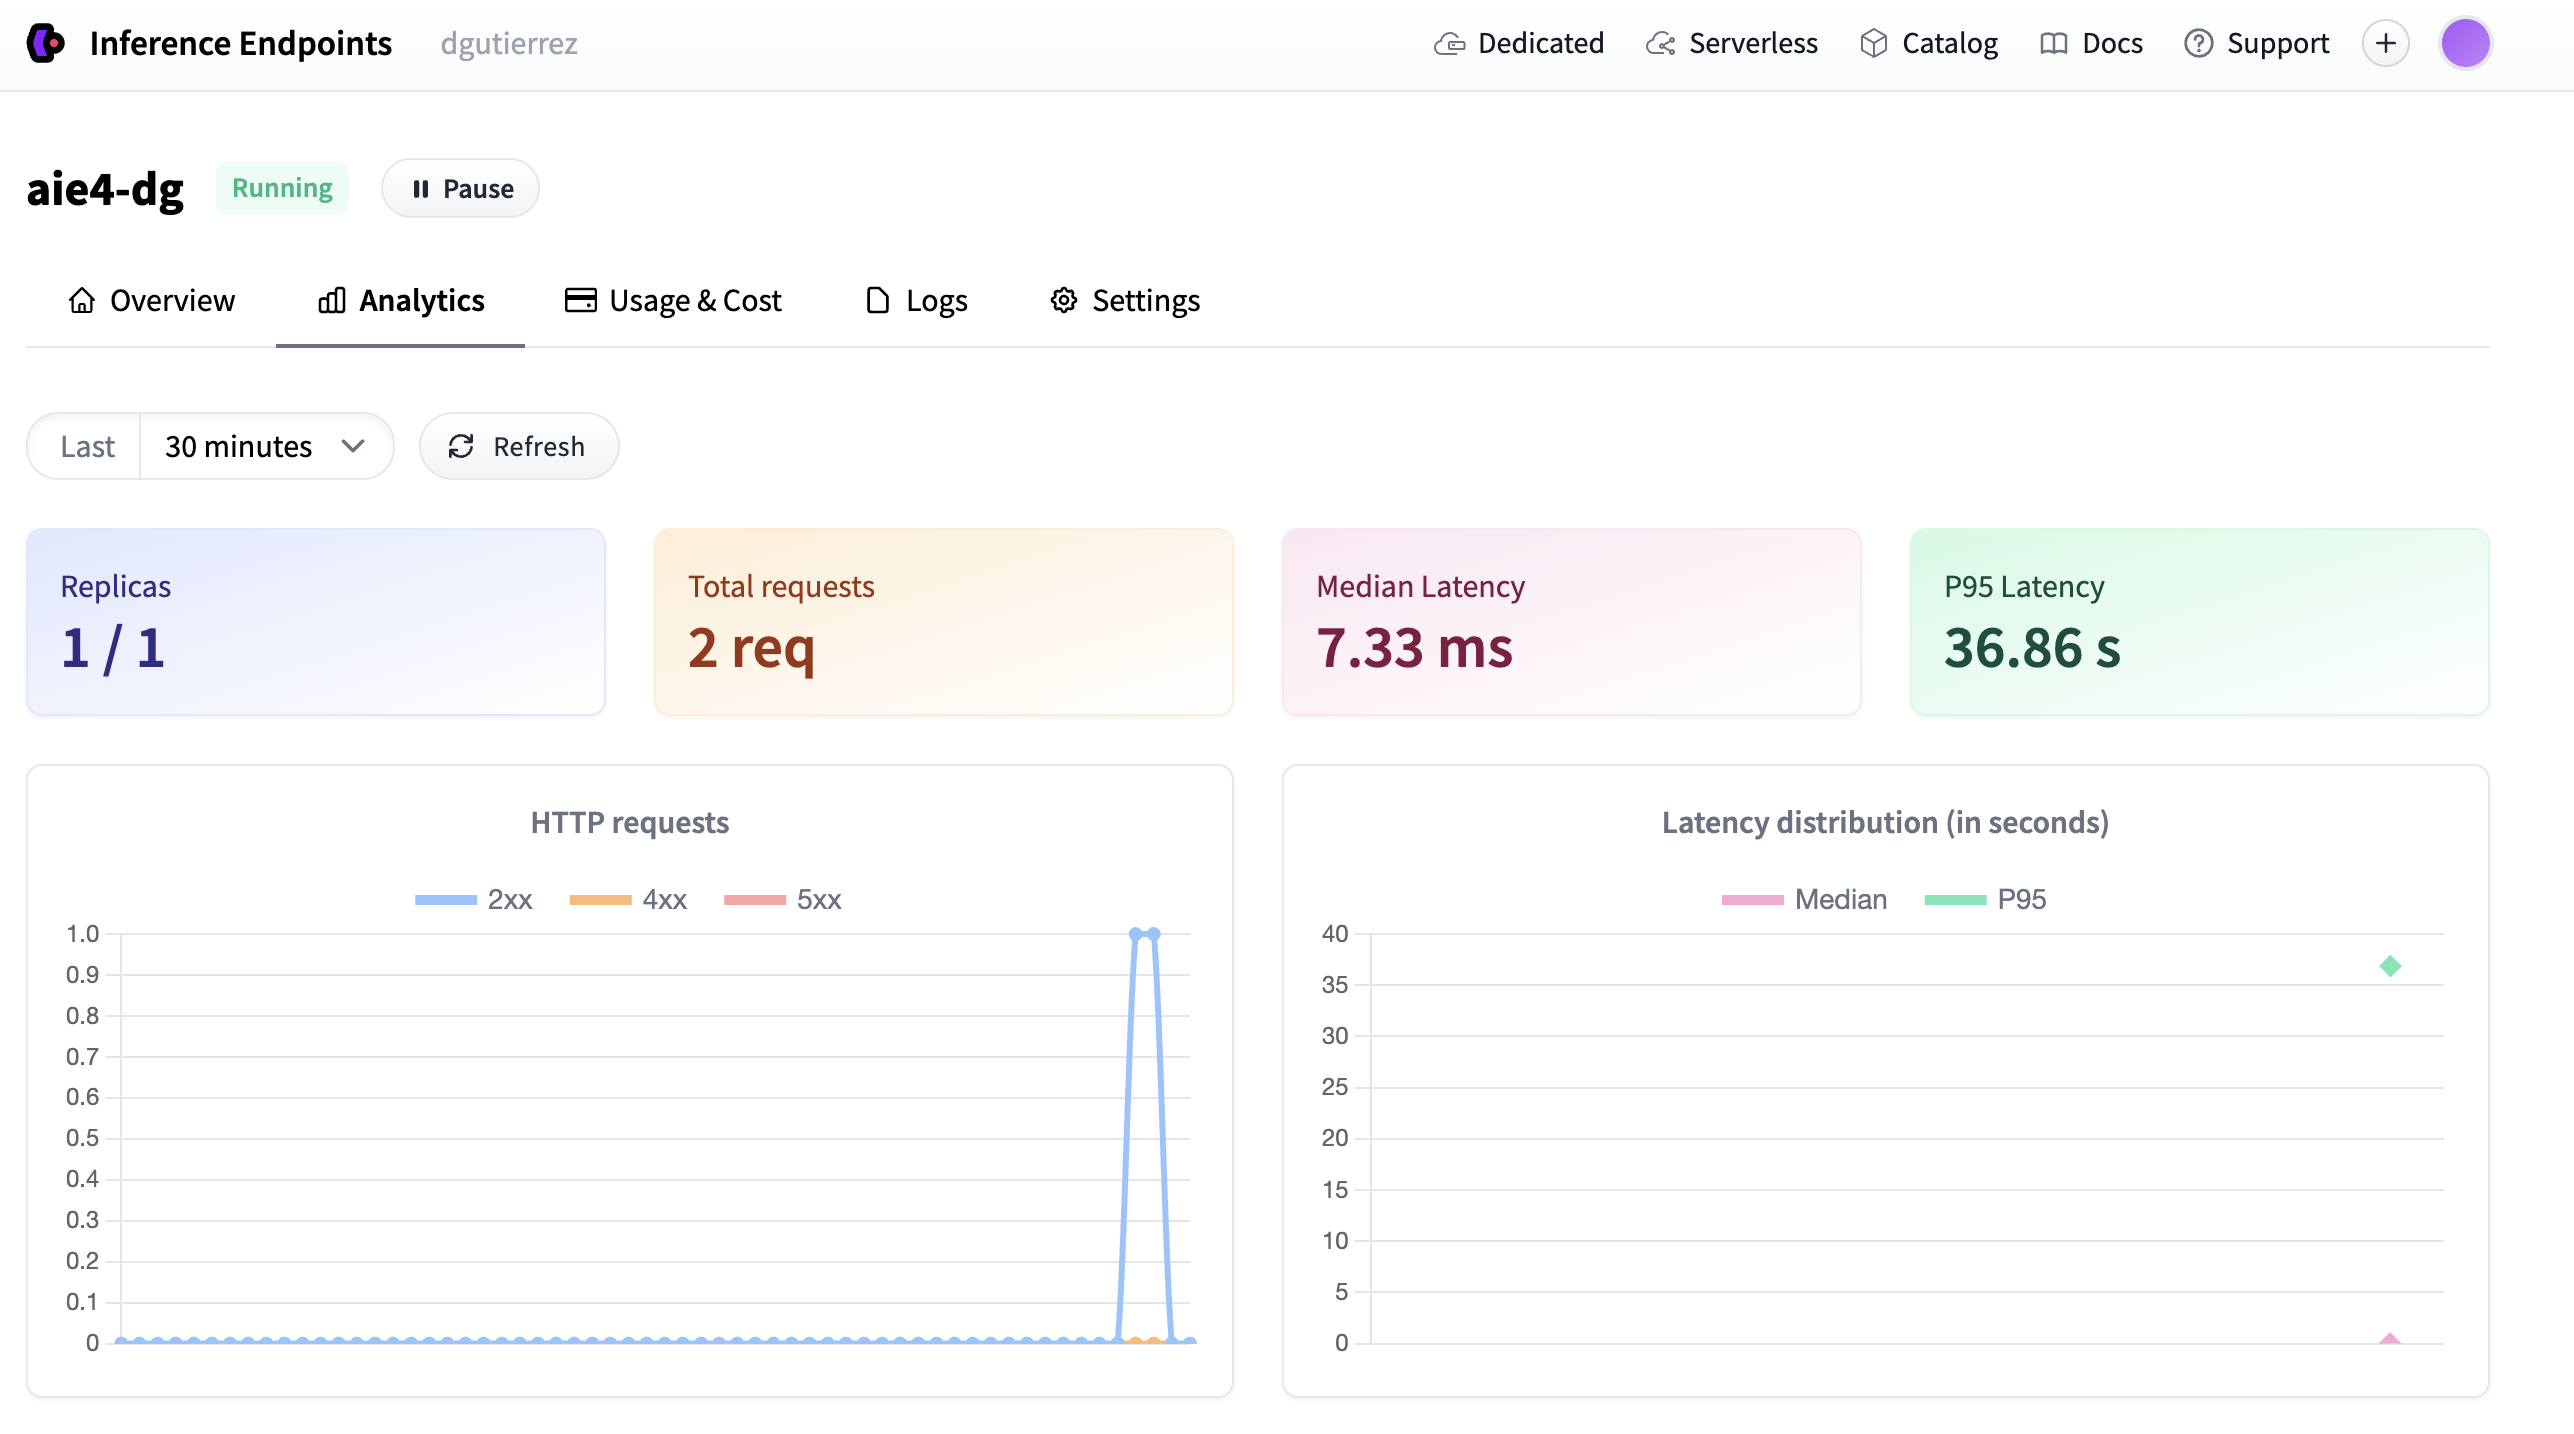